In [19]:
# Librerias Necesarias
import requests, os, h5netcdf, datetime, time, getpass, glob
import numpy as np
import xarray as xr
import matplotlib as mpl
from multiprocessing import Pool
from functools import partial
import pandas as pd
from bs4 import BeautifulSoup as BS
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter, HourLocator
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [2]:
# Necesario para abrir archivos grib (pronosticos del GFS y ECMWF)
!pip uninstall eccodes cfgrib -y
!pip install ecmwflibs
!pip install eccodes==1.3.1
!pip install cfgrib
import cfgrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for findlibs: filename=findlibs-0.0.5-py3-none-any.whl size=6954 sha256=93340ce73589cf16589d38e539a81b675241f909e8c90167f3e401d1c9e0b1ad
  Stored in directory: /root/.cache/pip/wheels/2e/67/14/22fa5b9fd9c41be520b37e908597d6a262803c0fcf2ba7c2c3
Successfully built findlibs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eccodes: filename=eccodes-1.3.1-py3-none-any.whl size=39050 sha256=a81e2d743579a819cf9f3964e1cf8cf359b0ca42bb97169ab1e42e63deedc1ad
  Stored in directory: /root/.cache/pip/wheels/2b/20/49/9979619aae36b997b5ac102b0c938558f6e0aaad2ac128a150
Successfully 

In [3]:
# Libreria de descargas s3fs. Necesaria para descargar desde modelo WRF desde AWS
!pip install s3fs
import s3fs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.4.0
    Uninstalling fsspec-2023.4.0:
      Successfully uninstalled fsspec-2023.4.0


In [4]:
# Instalo el buscador Firefox para realizar el web-scraping
!apt-get update
!apt install firefox
# Instalo la libreria Selenium para el webscraping
!pip install selenium

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,157 kB]
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,341 kB]
Get:14 http://secu

In [5]:
# De la libreria selenium importo modulos necesarios para el web-scraping
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver import FirefoxOptions
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

In [6]:
# Descargo e importo la libreria de mapas y proyecciones Cartopy
!pip install cartopy
import cartopy.crs as ccrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 73.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.3 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102756 sha256=9db7a2d79a35765fc046b3117e2dfa30b4245d45b5fdf2552af4852b51431570
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy


In [7]:
# Descargo el modulo de scrape_wunderground desde el repositorio git
url = "https://gitlab.com/mdeotoproschle/scrap_wunder/-/raw/main/scrape_wunderground.py?inline=false"
!wget --no-cache --backups=1 -O scrape_wunderground.py {url}

--2023-05-09 03:42:42--  https://gitlab.com/mdeotoproschle/scrap_wunder/-/raw/main/scrape_wunderground.py?inline=false
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10337 (10K) [application/octet-stream]
Saving to: ‘scrape_wunderground.py’

scrape_wunderground 100%[===================>]  10.09K  --.-KB/s    in 0s      

2023-05-09 03:42:42 (52.1 MB/s) - ‘scrape_wunderground.py’ saved [10337/10337]



In [8]:
# Importo la funcion descargada del git
import scrape_wunderground as scrape

In [9]:
# Libreria para descargar los pronosticos del modelo ECMWF
!pip install ecmwf-opendata
from ecmwf.opendata import Client
# Libreria de descarga ECWMF
#!pip install ecmwf-api-client
#from ecmwfapi import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ecmwf-opendata: filename=ecmwf_opendata-0.2.0-py3-none-any.whl size=19620 sha256=5d9c79e77213c06e41b77778804e41b2295a33401e533841350545eca298dd84
  Stored in directory: /root/.cache/pip/wheels/8a/23/f4/eed8e507e7ae509e28001a57989df930cf34ede73065edce75
  Created wheel for multiurl: filename=multiurl-0.2.1-py3-none-any.whl size=21097 sha256=13238e6d2a8d3468ad85923313d6e7c03c9c09b8ff38ca27a48a462132e720f7
  Stored in directory: /root/.cache/pip/wheels/01/01/39/e2518f9172b2ae75ea8d8dead504f7c9a70454f9622a8ad5d7
Successfully built ecmwf-opendata multiurl


In [10]:
################################################################################
# Informacion que se debe configurar

# Longitud, latitud bariloche
lon_bari, lat_bari = -71.30822, -41.14557

################################################################################
# OBSERVACIONES EMAS LOCALES
################################################################################
"""
# Defino manualmente la informacion "metadata" de estaciones cercanas a S.C. de Bariloche
# https://www.wunderground.com/wundermap?lat=-41.109&lon=-71.448
"""
estacion  = ["IDEPAR123", "IDEPAR138", "IBARIL3", "ISANCARL18", "IBARILOC6", "IBARILOC2", "ISANCARL19", "IDEPAR37", "ILOSLAGO6"]
elevacion = [  1620,    1437,    869,    775,    836,    859,    780,    932,    863]
latitud   = [-41.10,  -41.14, -41.13, -41.11, -41.08, -41.14, -41.13, -41.17, -41.00]
longitud  = [-71.57,  -71.38, -71.13, -71.42, -71.53, -71.32, -71.27, -71.37, -71.16]

"""
# Diccionario: informacion
"""
info      = {"estacion": estacion, "elevacion":elevacion, "latitud":latitud, "longitud":longitud}

"""
# Defino las fechas de interés. [Recomendacion no mas de 2 dias]
"""
date1     = "2023-05-08"
date2     = "2023-05-09"

"""
# Lista de fechas
"""
dates     = pd.date_range(date1, date2, freq='D')

################################################################################
# PRONOSTICOS
# Se descargan GFS, ECMWF y WRF
# Atencion ECMWF solo da pronosticos publicos hasta 2 dias antes del actual.  Inicializacion: 00 Steps: 240 
#           GFS  """""""""""""""""""""""""""" hasta 10 dias antes del actual. Inicializacion: 00 Steps: 
#           WRF  """""""""""""""""""""""""""" desde Abril del 2022.           Inicializacion: 00 Steps: 72
################################################################################

# DEFINICION DE SECTOR REGIONAL
lat_s, lat_n, lon_w, lon_e = -41.5, -40.5, -72.5, -70.75                        # Region rectangular

# DEFINICION DE FECHA PARA PRONOSTICO
year     = date1[0:4]
month    = date1[5:7]
day      = date1[8:10]
hour     = "00"                                                                    # inicializacion del pronostico "00" o "12"
maxstep  = "72"                                                                    # plazo de pronostico. Recordar que es hora utc

"""
# Setear el direcorio de salida de la informacion
"""
pathtofolder = "."
# Carpeta de los datos y figuras
outdir       = f"{pathtofolder}/data"
os.makedirs(outdir, exist_ok = True)
# carpeta temporal donde se descargan los datos (version paralelizada)
tmpdir       = f"{outdir}/tmp"
os.makedirs(tmpdir, exist_ok = True)

In [11]:
# Descargo observaciones de Zona Bariloche WUNDERGROUND
# Secuencial
dataframe = scrape.download(info, dates)
# Opcion de guardar la informacion
dataframe.to_csv(f"{outdir}/meteobari_{dates[0]:%Y%m%d}-{(dates[0] + pd.to_timedelta(1,'d')):%Y%m%d}.csv", sep=",", float_format="%.1f")

Ok estacion IDEPAR123 y fecha 2023-05-08 00:00:00
Error en la lectura de la estacion IDEPAR123 o la fechas 2023-05-09 00:00:00
Ok estacion IDEPAR138 y fecha 2023-05-08 00:00:00
Ok estacion IDEPAR138 y fecha 2023-05-09 00:00:00
Ok estacion IBARIL3 y fecha 2023-05-08 00:00:00
Ok estacion IBARIL3 y fecha 2023-05-09 00:00:00
Ok estacion ISANCARL18 y fecha 2023-05-08 00:00:00
Ok estacion ISANCARL18 y fecha 2023-05-09 00:00:00
Ok estacion IBARILOC6 y fecha 2023-05-08 00:00:00
Ok estacion IBARILOC6 y fecha 2023-05-09 00:00:00
Ok estacion IBARILOC2 y fecha 2023-05-08 00:00:00
Ok estacion IBARILOC2 y fecha 2023-05-09 00:00:00
Ok estacion ISANCARL19 y fecha 2023-05-08 00:00:00
Ok estacion ISANCARL19 y fecha 2023-05-09 00:00:00
Ok estacion IDEPAR37 y fecha 2023-05-08 00:00:00
Ok estacion IDEPAR37 y fecha 2023-05-09 00:00:00
Error en la lectura de la estacion ILOSLAGO6 o la fechas 2023-05-08 00:00:00
Error en la lectura de la estacion ILOSLAGO6 o la fechas 2023-05-09 00:00:00


In [12]:
################################################################################
# BIBLIOGRAFIA
# https://pypi.org/project/ecmwf-opendata/

"""
ATENCION: Hasta 2 dias antes se pueden descargar los pronosticos publicos de ECMWF
"""

client = Client()
client.retrieve(
    date=f"{year}-{month}-{day}",
    time=f"{hour}",
    step=[i for i in range(0, int(maxstep), 3)],
    type="fc",
    param="2t",
    levtype="sfc",
    area=f"{lat_n}/{lon_w}/{lat_s}/{lon_e}",                                    # North/West/South/East   
    target=f"{outdir}/ejemplo_ecmwf.grib",
)

<multiple>:   0%|          | 0.00/13.9M [00:00<?, ?B/s]

In [13]:
# Funcion de Descarga WRF-SMN desde (Amazon Web Service) AWS
# BIBLIOGRAFIA SUGERIDA
# 1. https://registry.opendata.aws/smn-ar-wrf-dataset/

date     = datetime.datetime(int(year), int(month), int(day), int(hour))
main_url = "smn-ar-wrf/DATA/WRF/DET"
s3_url   = [f'{main_url}/{date:%Y/%m/%d/%H}/WRFDETAR_01H_{date:%Y%m%d_%H}_{step:03d}.nc' for step in range(int(maxstep)+1)]

def download_wrf(tmpdir, url):
  fs     = s3fs.S3FileSystem(anon=True)
  if fs.exists(url):  # try
    fs.get(url, f"{tmpdir}/{os.path.basename(url)}")
  else:               # except
    print(f'El archivo {url} no existe')


In [14]:
# Descarga secuencial
for wurl in s3_url:
  download_wrf(tmpdir, wurl)

# # paralelizacion de las 72 horas de pronostico de WRF, se puede subdividir para no cargar tanto la ram
# for i in range(round(len(s3_url/6)):
#   surl = s3_url[i:i+6]
# pool    = Pool(processes=len(s3_url))
# func    = partial(download_wrf, tmpdir)
# result  = pool.map(func, s3_url)

In [32]:
# Descarga secuencial
# DESCARGA GFS DESDE
# BIBLIOGRAFIA SUGERIDA
# 1. https://rda.ucar.edu/datasets/ds084.1/dataaccess/

"""
# Crear usuario y contraseña en el sitio web rda.ucar.edu
# Introduce tu nombre de usuario y clave de acceso
"""
username = "###"
password = "###"
auth     = (username, password)


# Defino funcion
def download_gfs(auth, tmpdir, gurl):
  r        = requests.get(gurl, auth=auth)
  with open(f"{tmpdir}/{os.path.basename(gurl)}", "wb") as f:
      f.write(r.content)

# Establece la UnRL del archivo a descargar
main_url = "https://data.rda.ucar.edu/ds084.1"
# problema descarga con 1 dia de antelacion
day  = "07"
hour = "12"
gfs_url  = [f"{main_url}/{year}/{year}{month}{day}/gfs.0p25.{year}{month}{day}{hour}.f{(int(step)-int(step)%3):03d}.grib2" for step in range(0,int(maxstep)+3,3)]

# Descarga paralelizada
pool    = Pool(processes=len(gfs_url))
func    = partial(download_gfs, auth, tmpdir)
result  = pool.map(func, gfs_url)      

# # Descarga secuencial
# for gurl in gfs_url:
#   # Descarga el archivo utilizando tu nombre de usuario y clave de acceso
#   r        = requests.get(gurl, auth=(username, password))
#   # Guarda el archivo en tu sistema de archivos local
#   with open(f"{tmpdir}/{os.path.basename(gurl)}", "wb") as f:
#       f.write(r.content)

Process ForkPoolWorker-55:
Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Process ForkPoolWorker-52:
Process ForkPoolWorker-27:
Process ForkPoolWorker-43:
Process ForkPoolWorker-34:
Process ForkPoolWorker-53:
Process ForkPoolWorker-54:
Process ForkPoolWorker-44:
Process ForkPoolWorker-31:
Process ForkPoolWorker-32:
Process ForkPoolWorker-50:
Process ForkPoolWorker-42:
Process ForkPoolWorker-33:
Process ForkPoolWorker-59:
Process ForkPoolWorker-56:
Process ForkPoolWorker-36:
Process ForkPoolWorker-41:
Process ForkPoolWorker-60:
Process ForkPoolWorker-57:
Process ForkPoolWorker-37:
Process ForkPoolWorker-58:
Process ForkPoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (

KeyboardInterrupt: ignored

  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rl

In [44]:
################
# Load Files
################

# # Load ECMWF
# ecmwf = xr.open_dataset(f"{outdir}/ejemplo_ecmwf.grib", engine="cfgrib")

# # Load WRF
# wrf   = xr.open_mfdataset(f"{tmpdir}/WRFDETAR*", decode_coords = 'all', engine = 'h5netcdf')

# Load GFS
gfs_list = []
for gfiles in sorted(glob.glob(f"{tmpdir}/gfs*")):
  gfs_ = xr.open_dataset(gfiles, engine="cfgrib", backend_kwargs={'indexpath':''}, filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level': 2})
  gfs_list.append(gfs_)

gfs   = xr.concat(gfs_list, dim = "time") 

#gfs   = xr.open_mfdataset(f"{tmpdir}/gfs*", concat_dim="time", combine='nested', engine="cfgrib", backend_kwargs={'indexpath':''}, filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level': 2})

In [45]:
#########################################
# Selecciono latitud longitud target
#########################################
# ECMWF
ecmwf_tar  = ecmwf.sel(latitude=lat_bari, longitude=lon_bari, method="nearest")
ecmwf_time = ecmwf_tar["time"] + ecmwf_tar["step"] - pd.Timedelta(hours=3)

# WRF
data_crs = ccrs.LambertConformal(central_longitude = wrf['Lambert_Conformal'].attrs['longitude_of_central_meridian'],
                                 central_latitude = wrf['Lambert_Conformal'].attrs['latitude_of_projection_origin'],
                                 standard_parallels = wrf['Lambert_Conformal'].attrs['standard_parallel'])

x, y       = data_crs.transform_point(lon_bari, lat_bari, src_crs=ccrs.PlateCarree())
wrf_tar    = wrf.sel(dict(x = x, y = y), method = 'nearest')
wrf_time   = wrf_tar["time"] - pd.Timedelta(hours=3)

# GFS
gfs_tar    = gfs.sel(latitude=lat_bari, longitude=lon_bari+360., method="nearest")
gfs_time   = gfs_tar["time"] + gfs_tar["step"] - pd.Timedelta(hours=3)

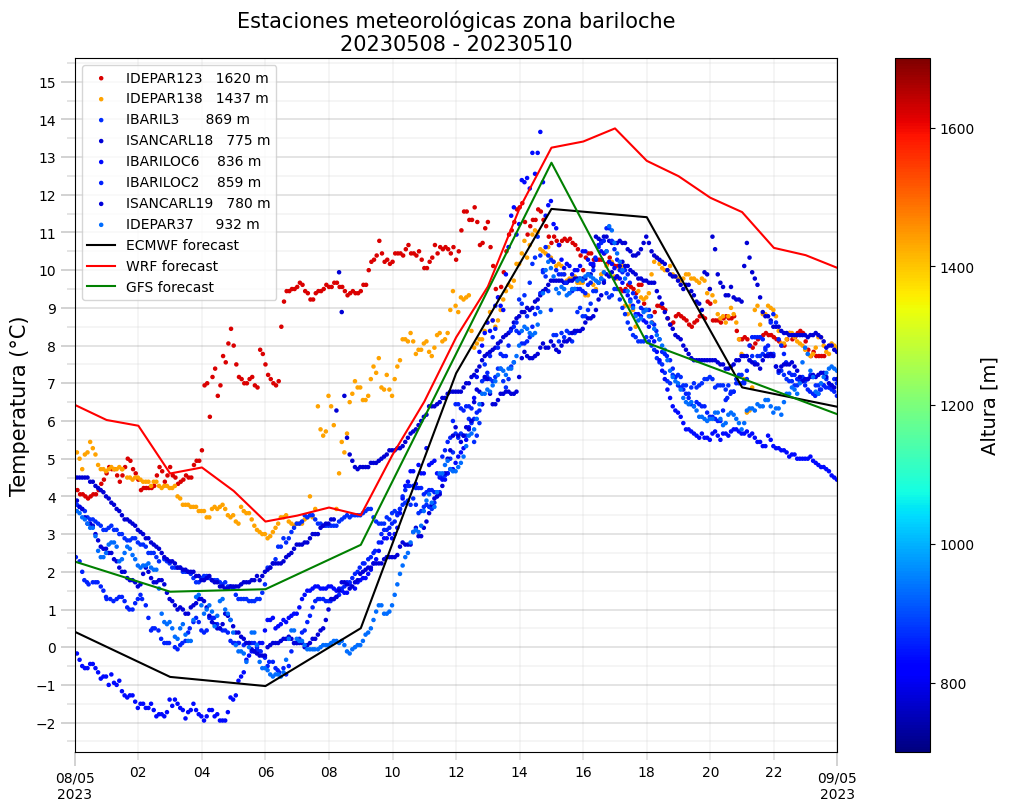

In [46]:
fig, ax = plt.subplots(figsize=(10, 8), layout='constrained')

for st in info["estacion"]:
  if not dataframe["Temperature"][dataframe["estacion"]==st].empty: # Elimino las estaciones que no tienen datos
    T    = dataframe["Temperature"][dataframe["estacion"]==st]
    elev = dataframe["elevacion"][dataframe["estacion"]==st]
    cs = ax.scatter(dataframe[dataframe["estacion"]==st].index, T, c=elev, cmap="jet", s=5, label=f"{st:10s} {elev[0]:5d} m".expandtabs(), vmin=700, vmax=1700)

# Modelos
ax.plot(ecmwf_time, ecmwf_tar["t2m"]-273.15, ls="-", lw=1.5, color="black", label= "ECMWF forecast")
ax.plot(wrf_time, wrf_tar["T2"], ls="-", lw=1.5, color="red", label= "WRF forecast")
ax.plot(gfs_time, gfs_tar["t2m"]-273.15, ls="-", lw=1.5, color="green", label= "GFS forecast")

ax.set_ylabel('Temperatura (°C)', fontsize=15)
ax.set_title(f"Estaciones meteorológicas zona bariloche\n{dates[0]:%Y%m%d} - {(dates[1] + pd.to_timedelta(1,'d')):%Y%m%d}", fontsize=15)     # Add a title to the axes.
#ax.set_title(f"Estaciones meteorológicas zona bariloche\n{dates[0]:%Y%m%d}", fontsize=15)     # Add a title to the axes.
ax.yaxis.set_major_locator(MultipleLocator(1.00))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.set_major_locator(DayLocator(interval = 1))
ax.xaxis.set_minor_locator(HourLocator(interval = 2))
ax.set_xlim(dates[0], dates[0] + pd.to_timedelta(1,'d'))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m\n%Y'))
ax.xaxis.set_minor_formatter(DateFormatter('%H'))
ax.yaxis.set_tick_params(labelsize = 10)
ax.xaxis.set_tick_params(labelsize = 10)
ax.grid(True, which = "major", axis = "both", ls = "-", lw = 0.3, c = "0.5")
ax.grid(True, which = "minor", axis = "both", ls = "-", lw = 0.2, c = "0.75")
ax.set_axisbelow(True)
ax.tick_params(which = 'major', width = 0.25, length = 10)
ax.tick_params(which = 'minor', width = 0.15, length = 6)
ax.legend()                     # Add a legend.

cbar = plt.colorbar(cs)
cbar.set_label('Altura [m]', rotation=90, fontsize=14)

#plt.show()
plt.savefig(f'{outdir}/plot_temp.png', bbox_inches='tight')